# Decision_Tree

Why are we learning about decision trees?

- Can be applied to both regression and classification problems
- Many useful properties
- Very popular
- Basis for more sophisticated models
- Have a different way of "thinking" than the other models we have studied

## Lesson objectives

Students will be able to:

- Explain how a decision tree is created
- Build a decision tree model in scikit-learn
- Tune a decision tree model and explain how tuning impacts the model
- Interpret a tree diagram
- Describe the key differences between regression and classification trees
- Decide whether a decision tree is an appropriate model for a given problem

# Part 1: Regression trees

Major League Baseball player data from 1986-87:

- **Years** (x-axis): number of years playing in the major leagues
- **Hits** (y-axis): number of hits in the previous year
- **Salary** (color): low salary is blue/green, high salary is red/yellow

![Salary data](images/salary_color.png)

Exercise:

- The data above is our **training data**.
- We want to build a model that predicts the Salary of **future players** based on Years and Hits.
- We are going to "segment" the feature space into regions, and then use the **mean Salary in each region** as the predicted Salary for future players.
- Intuitively, you want to **maximize** the similarity (or "homogeneity") within a given region, and **minimize** the similarity between different regions.

Rules for segmenting:

- You can only use **straight lines**, drawn one at a time.
- Your line must either be **vertical or horizontal**.
- Your line **stops** when it hits an existing line.

![Salary regions](images/salary_regions.png)

Above are the regions created by a computer:

- $R_1$: players with **less than 5 years** of experience, mean Salary of **\$166,000 **
- $R_2$: players with **5 or more years** of experience and **less than 118 hits**, mean Salary of **\$403,000 **
- $R_3$: players with **5 or more years** of experience and **118 hits or more**, mean Salary of **\$846,000 **

**Note:** Years and Hits are both integers, but the convention is to use the **midpoint** between adjacent values to label a split.

These regions are used to make predictions on **out-of-sample data**. Thus, there are only three possible predictions! (Is this different from how **linear regression** makes predictions?)

Below is the equivalent regression tree:

![Salary tree](images/salary_tree.png)

The first split is **Years < 4.5**, thus that split goes at the top of the tree. When a splitting rule is **True**, you follow the left branch. When a splitting rule is **False**, you follow the right branch.

For players in the **left branch**, the mean Salary is \$166,000, thus you label it with that value. (Salary has been divided by 1000 and log-transformed to 5.11.)

For players in the **right branch**, there is a further split on **Hits < 117.5**, dividing players into two more Salary regions: \$403,000 (transformed to 6.00), and \$846,000 (transformed to 6.74).

![Salary tree annotated](images/salary_tree_annotated.png)

**What does this tree tell you about your data?**

- Years is the most important factor determining Salary, with a lower number of Years corresponding to a lower Salary.
- For a player with a lower number of Years, Hits is not an important factor determining Salary.
- For a player with a higher number of Years, Hits is an important factor determining Salary, with a greater number of Hits corresponding to a higher Salary.

**Question:** What do you like and dislike about decision trees so far?

## Building a regression tree by hand

Your **training data** is a tiny dataset of [used vehicle sale prices](https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv). Your goal is to **predict price** for testing data.

1. Read the data into a Pandas DataFrame.
2. Explore the data by sorting, plotting, or split-apply-combine (aka `group_by`).
3. Decide which feature is the most important predictor, and use that to create your first splitting rule.
    - Only binary splits are allowed.
4. After making your first split, split your DataFrame into two parts, and then explore each part to figure out what other splits to make.
5. Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting.
    - Your goal is to build a model that generalizes well.
    - You are allowed to split on the same variable multiple times!
6. Draw your tree, labeling the leaves with the mean price for the observations in that region.
    - Make sure nothing is backwards: You follow the **left branch** if the rule is true, and the **right branch** if the rule is false.

## How does a computer build a regression tree?

**Ideal approach:** Consider every possible partition of the feature space (computationally infeasible)

**"Good enough" approach:** recursive binary splitting

1. Begin at the top of the tree.
2. For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint such that the resulting tree has the lowest possible mean squared error (MSE). Make that split.
3. Examine the two resulting regions, and again make a **single split** (in one of the regions) to minimize the MSE.
4. Keep repeating step 3 until a **stopping criterion** is met:
    - maximum tree depth (maximum number of splits required to arrive at a leaf)
    - minimum number of observations in a leaf

### Demo: Choosing the ideal cutpoint for a given feature

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#___________Stats lib

from sklearn.tree import DecisionTreeClassifier as dtc,DecisionTreeRegressor as dtr
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
# vehicle data
train = pd.read_csv('D:\Data\Docs_\Rohan_DA\ALABS\___STATS___ -  cls 10 onwards\class 17_DT_Ensemble\Decision Tree and Ensemble Learning files/vehicles_train.csv')

In [5]:
train.head()

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car


In [40]:
train['predict'] =  train.price.mean()
train

,price,year,miles,doors,type,predict
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [41]:
# calculate RMSE for those predictions
from sklearn import metrics
import numpy as np

## we have used metrics here 
## basically metrics is used for calc parameters based on train and test sets 
## like roc_value,accuracy_value,gini value
np.sqrt(metrics.mean_squared_error(train.price, train.predict))

5936.981985995983

### Decision_Tree_regression working

This is basically what happens at the backend for DT_regression.

DT first divides a dataset into segemnts(we have divided into 2 seg).the no. and position to divide the segemnt depends on lowering the rms value for the whole data.

Mean value is calc for each segment, This is the predicted value.Now if we have to predict an unknown obs. we first check in which segment it lies and then accordingly assign the mean value(of the segment) to that obs.

In [42]:
# define a function that calculates the RMSE for a given split of miles
def mileage_split(miles):
    lower_mileage_price = train[train.miles < miles].price.mean()
    higher_mileage_price = train[train.miles >= miles].price.mean()
    train['prediction'] = np.where(train.miles < miles, lower_mileage_price, higher_mileage_price)
    return np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

In [43]:
# calculate RMSE for tree which splits on miles < 50000
print('RMSE:', mileage_split(50000))
train

RMSE: 3984.0917425414564


,price,year,miles,doors,type,predict,prediction
0,22000,2012,13000,2,car,6571.428571,15000.000000
1,14000,2010,30000,2,car,6571.428571,15000.000000
2,13000,2010,73500,4,car,6571.428571,4272.727273
3,9500,2009,78000,4,car,6571.428571,4272.727273
4,9000,2007,47000,4,car,6571.428571,15000.000000
5,4000,2006,124000,2,car,6571.428571,4272.727273
6,3000,2004,177000,4,car,6571.428571,4272.727273
7,2000,2004,209000,4,truck,6571.428571,4272.727273
8,3000,2003,138000,2,car,6571.428571,4272.727273
9,1900,2003,160000,4,car,6571.428571,4272.727273


### How does Min_RMSE logic work

Here we are simply calc RMSE value for all possible splits, The idea is to select the cutoff which yields the minimum value for RMSE. Moreover, we have already chosen mileage to be the var to split upon.

This process would be repeated for all the var. so we get the min RMSE value for each var and then out of those min_RMSE values we will select the variable with the min RMSE value to split upon first. 

In [44]:
# check all possible mileage splits
mileage_range = range(train.miles.min(), train.miles.max(), 1000)
RMSE = [pd.DataFrame([mileage_split(miles)]) for miles in mileage_range]
pd.DataFrame(RMSE).head(2)

,0
0,5936.981986
1,4115.449317


### Just tried creating the dataframe for cutoff,RMS value at a single go

In [45]:
store = pd.DataFrame()
for x in range(10000,500000,10000):
    var = [mileage_split(x),x]
    ser = pd.DataFrame([[x,mileage_split(x)]],columns= ['cutoff','RMS'])
    store = pd.concat([store,ser])

In [46]:
store.head(2)
#pd.Series(var)

,cutoff,RMS
0,10000,5936.981986
0,20000,4115.449317


In [47]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

Text(0,0.5,'RMSE (lower is better)')

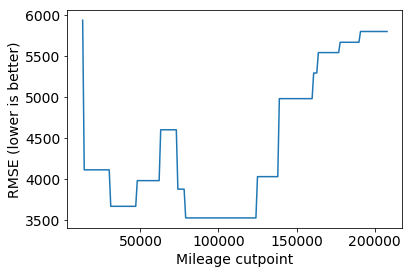

In [48]:
# plot mileage cutpoint (x-axis) versus RMSE (y-axis)
plt.plot(mileage_range, RMSE)
plt.xlabel('Mileage cutpoint')
plt.ylabel('RMSE (lower is better)')

#### Notice "the feature and the cutpoint",This simply means we select the min of min_RMSE for all the var. selected at once

**Recap:** Before every split, this process is repeated for every feature, and the feature and cutpoint that produces the lowest MSE is chosen.

- For a classification tree, the same process will be used, and we will measure the Entropy at for each variable, for each value of that variable. 
- The variable + value combination that yields the lowest Entropy will be chosen as the splitting rule.

## Building a regression tree in scikit-learn

In [49]:
train.head(2)

,price,year,miles,doors,type,predict,prediction
0,22000,2012,13000,2,car,6571.428571,6571.428571
1,14000,2010,30000,2,car,6571.428571,6571.428571


In [50]:
train['vtype'] = train.type.map({'car':1,'truck':0})

In [51]:
#train.drop(columns= 'v_type',inplace=True)

In [52]:
train.head(2)

,price,year,miles,doors,type,predict,prediction,vtype
0,22000,2012,13000,2,car,6571.428571,6571.428571,1
1,14000,2010,30000,2,car,6571.428571,6571.428571,1


In [53]:
# define X and y
feature_cols = ['year', 'miles', 'doors', 'vtype']
X = train[feature_cols]
y = train.price

In [54]:
# instantiate a DecisionTreeRegressor (with random_state=1)
treereg = dtr(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

### K_fold cross_validation

In [55]:
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model
score = cross_val_score(treereg,X=X,y=y,cv = 14,scoring= 'neg_mean_squared_error')
score

np.sqrt(-score).mean()

3107.1428571428573

## What happens when we grow a tree too deep?

- Left: Regression tree for Salary **grown deeper**
- Right: Comparison of the **training, testing, and cross-validation errors** for trees with different numbers of leaves

![Salary tree grown deep](images/salary_tree_deep.png)

The **training error** continues to go down as the tree size increases (due to overfitting), but the lowest **cross-validation error** occurs for a tree with 3 leaves.

## Tuning a regression tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

In [56]:
RMSE_scores = []

for depth in range(1,8):
    treereg1 = dtr(max_depth=depth,random_state=1)
    MSE_scores = cross_val_score(treereg1, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.sqrt(-MSE_scores).mean())

In [57]:
RMSE_scores

[4050.1443001443,
 3345.238095238095,
 3002.3809523809527,
 3125.0,
 3107.1428571428573,
 3107.1428571428573,
 3107.1428571428573]

Text(0,0.5,'RMSE (lower is better)')

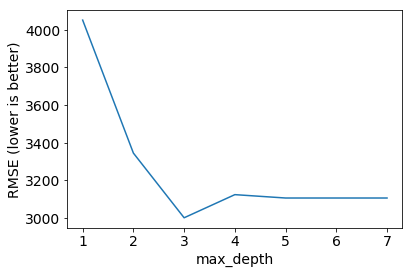

In [58]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(range(1,8), RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [59]:
# max_depth=3 was best, so fit a tree using that parameter
treereg = dtr(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [60]:
treereg.feature_importances_

array([0.79874419, 0.20125581, 0.        , 0.        ])

In [61]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,vtype,0.000000


In [62]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_vehicles.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
# dot tree_vehicles.dot -Tpng -o tree_vehicles.png - worked
#   dot -Tpng tree_vehicles.dot -o tree_vehicles.png

![Tree for vehicle data](images/tree_vehicles.png)

Reading the internal nodes:

- **samples:** number of observations in that node before splitting
- **mse:** MSE calculated by comparing the actual response values in that node against the mean response value in that node
- **rule:** rule used to split that node (go left if true, go right if false)

Reading the leaves:

- **samples:** number of observations in that node
- **value:** mean response value in that node
- **mse:** MSE calculated by comparing the actual response values in that node against "value"

## Making predictions `for the testing data

In [63]:
# vehicle data
test = pd.read_csv('/home/rohan/Documents/ROHAN_DA/ALABS/___STATS___ -  cls 10 onwards/class 17_Decision_Tree/Decision Tree and Ensemble Learning files/vehicles_test.csv')

In [64]:
test['vtype'] = test.type.map({'truck':0,'car':1})
test

,price,year,miles,doors,type,vtype
0,3000,2003,130000,4,truck,0
1,6000,2005,82500,4,car,1
2,12000,2010,60000,2,car,1


In [65]:
## while predicting values we have used feature_cols ['year', 'miles', 'doors', 'vtype']
## if instead we provide the training set to be [ 'miles', 'year','doors', 'vtype'] in this order, it will 
## give wrong result coz we are providing (x2,x1,x3,x4) for a model trained for (x1,2,3,4). So basically the
## segement it must be atking the mean value(for prediction) value would be different.


# use fitted model to make predictions on testing data
X_test = test[feature_cols]
y_test = test.price

y_pred = treereg.predict(X_test)
y_pred

array([ 4000.,  5000., 13500.])

In [66]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1190.2380714238084

In [67]:
# calculate RMSE for your own tree!
y_test = [3000, 6000, 12000]
y_pred = [2900, 6100, 11500]

from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

300.0

# Part 2: Classification trees

**Example:** Predict whether Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008:

![Obama-Clinton decision tree](images/obama_clinton_tree.jpg)

**Questions:**

- What are the observations? How many observations are there?
- What is the response variable?
- What are the features?
- What is the most predictive feature?
- Why does the tree split on high school graduation rate twice in a row?
- What is the class prediction for the following county: 15% African-American, 90% high school graduation rate, located in the South, high poverty, high population density?
- What is the predicted probability for that same county?

## Comparing regression trees and classification trees

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize Gini index (discussed below)|

## Splitting criteria for classification trees

Common options for the splitting criteria:

- **classification error rate:** fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a region`

### Example of classification error rate

Pretend we are predicting whether someone buys an iPhone or an Android:

- At a particular node, there are **25 observations** (phone buyers), of whom **10 bought iPhones and 15 bought Androids**.
- Since the majority class is **Android**, that's our prediction for all 25 observations, and thus the classification error rate is **10/25 = 40%**.

Our goal in making splits is to **reduce the classification error rate**. Let's try splitting on gender:

- **Males:** 2 iPhones and 12 Androids, thus the predicted class is Android
- **Females:** 8 iPhones and 3 Androids, thus the predicted class is iPhone
- Classification error rate after this split would be **5/25 = 20%**

Compare that with a split on age:

- **30 or younger:** 4 iPhones and 8 Androids, thus the predicted class is Android
- **31 or older:** 6 iPhones and 7 Androids, thus the predicted class is Android
- Classification error rate after this split would be **10/25 = 40%**

The decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most.**

### Example of Gini index

Calculate the Gini index before making a split:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- The **maximum value** of the Gini index is 0.5, and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of the Gini index is 0, and occurs when there is only one class represented in a node.
- A node with a lower Gini index is said to be more "pure".

Evaluating the split on **gender** using Gini index:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluating the split on **age** using Gini index:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Again, the decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini index (and thus increases the "node purity") the most.**

### Comparing classification error rate and Gini index

- Gini index is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate.
- Node purity is important because we're interested in the **class proportions** in each region, since that's how we calculate the **predicted probability** of each class.
- scikit-learn's default splitting criteria for classification trees is Gini index.

Note: There is another common splitting criteria called **cross-entropy**. It's numerically similar to Gini index, but slower to compute, thus it's not as popular as Gini index.

## Building a classification tree in scikit-learn

We'll build a classification tree using the Titanic data:


Titanic Data Variables

- **Sibsp** - # of siblings onboard
- **Parch** - # of Parentd/Children onboard
- **Embarked** - location at which ship was embarked 

- **Survived:** 0=died, 1=survived (response variable)
- **Pclass:** 1=first class, 2=second class, 3=third class
    - What will happen if the tree splits on this feature?
- **Sex:** 0=female, 1=male
- **Age:** numeric value
- **Embarked:** C or Q or S

In [68]:
t = metrics.make_scorer('neg_median_absolute_error', greater_is_better=False,beta = 2)
t.__class__

sklearn.metrics.scorer._PredictScorer

In [69]:
#metrics.SCORERS

In [71]:
# ## Alternatively

# test = pd.read_csv('/home/rohan/Documents/ROHAN_DA/UDEMY/Refactored_Py_DS_ML_Bootcamp-master/13-Logistic-Regression/titanic_train.csv')
# test = pd.get_dummies(data = test, prefix='E_',columns=['Embarked'],drop_first= True)
# test.head()

# #test.Embarked.unique()

In [72]:
# read in the data
titanic = pd.read_csv('/home/rohan/Documents/ROHAN_DA/UDEMY/Refactored_Py_DS_ML_Bootcamp-master/13-Logistic-Regression/titanic_train.csv')

# encode female as 0 and male as 1
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# fill in the missing values for age with the median age
# median coz age is ordinal not continuos
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# print the updated DataFrame
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1


In [73]:
# define X and y
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [74]:
# fit a classification tree with max_depth=3 on all data
treeclf = dtc(criterion='gini',max_depth=3,random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [75]:
## Using gridsearch cv to select the most optimum paramteres for DT

## basically gridsearch cv is also a regressor which can take in multiple (meta_parameters) and build
## multiple models accordingly

For evaluating multiple metrics, either give a list of (unique) strings or a dict with names as keys and callables as values.

In [76]:
pGrid = {'max_depth': [2, 4, 6, 8],
        'min_samples_leaf': [20, 40, 60],
        'min_samples_split': [75, 100]}

gscv_dt = GridSearchCV(estimator=dtc(), param_grid=pGrid, cv=5,
                       scoring='recall', verbose=True)

In [77]:
gscv_dt

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [20, 40, 60], 'min_samples_split': [75, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=True)

In [78]:
gscv_dt.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [20, 40, 60], 'min_samples_split': [75, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=True)

In [79]:
print(gscv_dt.best_params_)
print(gscv_dt.best_score_)
print(gscv_dt.error_score)


{'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 75}
0.6139255585120887
raise


- **best_Estimator Model**

In [80]:
gscv_dt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=75,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Measuring the quality of the best fit model(chosen from gridsearch cv)

In [81]:
print(accuracy_score(y, gscv_dt.best_estimator_.predict(X)))

0.8204264870931538


In [82]:
pd.DataFrame(list(zip(gscv_dt.best_estimator_.feature_importances_, X.columns)),columns=['feature_importance','features'])

,feature_importance,features
0,0.221280,Pclass
1,0.651718,Sex
2,0.088935,Age
3,0.000000,Embarked_Q
4,0.038068,Embarked_S


In [83]:
# create a Graphviz file
export_graphviz(treeclf, out_file='tree_titanic.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

![Tree for Titanic data](images/tree_titanic.png)

Notice the split in the bottom right: the **same class** is predicted in both of its leaves. That split didn't affect the **classification error rate**, though it did increase the **node purity**, which is important because it increases the accuracy of our predicted probabilities.

In [84]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,Pclass,0.242664
1,Sex,0.655584
2,Age,0.064494
3,Embarked_Q,0.000000
4,Embarked_S,0.037258


# Part 3: Comparing decision trees with other models

**Advantages of decision trees:**

- Can be used for regression or classification
- Can be displayed graphically
- Highly interpretable
- Can be specified as a series of rules, and more closely approximate human decision-making than other models
- Prediction is fast
- Features don't need scaling
- Automatically learns feature interactions
- Tends to ignore irrelevant features
- Non-parametric (will outperform linear models if relationship between features and response is highly non-linear)

![Trees versus linear models](images/tree_vs_linear.png)

**Disadvantages of decision trees:**

- Performance is (generally) not competitive with the best supervised learning methods
    - Use Ensembles 
- Can easily overfit the training data (tuning is required)
    - Use GridSearch
- Small variations in the data can result in a completely different tree (high variance)
    - Use Ensembles to reduce the variance
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Doesn't tend to work well if the classes are highly unbalanced
- Doesn't tend to work well with very small datasets

In [85]:
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)


array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

In [86]:
y_true = [0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [0, 1, 0, 1, 0, 1, 0, 1]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp


(2, 1, 2, 3)

In [87]:
y_true = [0, 1, 2, 2, 0]
y_pred = [0, 0, 2, 1, 0]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))



             precision    recall  f1-score   support

    class 0       0.67      1.00      0.80         2
    class 1       0.00      0.00      0.00         1
    class 2       1.00      0.50      0.67         2

avg / total       0.67      0.60      0.59         5



# ------------------------------------------------------------------------------------------------------


# __________________ HR ANALYTICS _________________________

### HR - Attrition Analytics -  Exploratory Analysis & Predictive Modeling
> Human Resources are critical resources of any organiazation. Organizations spend huge amount of time and money to hire <br>
> and nuture their employees. It is a huge loss for companies if employees leave, especially the key resources.  <br>
> So if HR can predict weather employees are at risk for leaving the company, it will allow them to identify the attrition  <br>
> risks and help understand and provie necessary support to retain those employees or do preventive hiring to minimize the  <br>
> impact to the orgranization.

### DATA ATRRIBUTES

satisfaction_level: Employee satisfaction level <br>
last_evaluation: Last evaluation  <br>
number_project: Number of projects  <br>
average_montly_hours: Average monthly hours <br>
time_spend_company: Time spent at the company <br>
Work_accident: Whether they have had a work accident <br>
promotion_last_5years: Whether they have had a promotion in the last 5 years <br>
department: Department <br>
salary: Salary <br>
left: Whether the employee has left <br>

## Aim : To predict whether the employee is gonna leave or not

In [3]:
## Importing ML & CV libraries

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import sklearn.metrics


from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn.grid_search import GridSearchCV

In [4]:
hr_df = pd.read_csv('/home/rohan/Documents/ROHAN_DA/ALABS/___STATS___ -  cls 10 onwards/class 17_DT_Ensemble/Decision Tree and Ensemble Learning files/HR Analytics Case Study - Class/HR_comma_sep.csv')

In [5]:
hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
## No missing values

hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
## outlier Mapping - No outlier, Data looks well distributed

hr_df.describe(percentiles=[.01,.05,.25,.5,.75,.9,.95,.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,95%,99%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.09,0.11,0.44,0.64,0.82,0.92,0.96,0.99,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.39,0.46,0.56,0.72,0.87,0.95,0.98,1.00,1.0
number_project,14999.0,3.803054,1.232592,2.00,2.00,2.00,3.00,4.00,5.00,5.00,6.00,7.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,104.00,130.00,156.00,200.00,245.00,267.00,275.00,301.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,2.00,2.00,3.00,3.00,4.00,5.00,6.00,10.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0


The summary statistics for Work_accident, left and promotion_last_5years does not make sense, as they are categorical variables

### PREDICTIVE MODEL: Build a model to predict if an employee will leave the company

In [8]:
hr_df.select_dtypes('object').columns

Index(['department', 'salary'], dtype='object')

In [9]:
hr_df._get_numeric_data().columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years'],
      dtype='object')

In [10]:
hr_df = pd.get_dummies(data= hr_df,columns=hr_df.select_dtypes('object').columns,drop_first=True)

In [11]:
hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


### Creating test_train splits 

In [12]:
X_col = hr_df.columns.difference(['left'])
Y_col = hr_df.left

In [13]:
train_X, test_X, train_y, test_y = train_test_split(hr_df[X_col],hr_df.left,test_size = .25,random_state = 42)

In [14]:
## instantitating and fitting a DT_Classifier

clf_tree = DecisionTreeClassifier(max_depth=3,criterion= 'gini')
clf_tree.fit(train_X,train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Predict_Proba for DT

In [15]:
## Here we are calc probability for DT.
## This must be calc by taking propotions of y=1/0 wrt Total for the segment in which the value(x) lies.

## Basically intead of mode, we are taking the proportion.

pd.DataFrame(clf_tree.predict_proba(train_X),columns=['Prob_y=1','Prob_y=0']).head()

,Prob_y=1,Prob_y=0
0,0.922541,0.077459
1,0.282249,0.717751
2,0.985990,0.014010
3,0.985990,0.014010
4,0.985990,0.014010


In [16]:
## preidcting the actual values(Using the majority voting approach)

tree_train_pred = pd.DataFrame({'Actual':train_y,'Predicted':clf_tree.predict(train_X)})
tree_train_pred.head()

,Actual,Predicted
14480,1,0
1934,1,1
7900,0,0
2952,0,0
4367,0,0


In [18]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': clf_tree.predict( test_X ) } )
tree_test_pred.head()

,actual,predicted
6723,0,0
6473,0,0
4679,0,0
862,1,1
7286,0,0


## Attributes of DT classifier

In [28]:
#clf_tree.score()  #simply gives the acccuracy for clf_tree fitted model.

In [19]:
clf_tree.classes_ ## gives the no. of classes we are working with, here we have only two 
# (person will stay, person will not stay)

array([0, 1])

In [20]:
clf_tree.criterion ## criteria for creating DT segments

'gini'

In [21]:
# clf_tree.feature_importances_ #- later discussed

## gives **relatuve** importancs of each var, preferably used for ensemble models

In [22]:
clf_tree.get_params ## gives you the param for the used DT

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [23]:
clf_tree.max_features_ ## applicable for boosting not bagging


## by default here it takes all the values of 'n' 
## can be log2(n) or root(n) , check documentation

18

## Evaluating the model performance

###  Accuracy(Classifier)

#### 3 Ways of calc the model performance for a DT

- Basically metrics has score(function) that the DT_classifier can also use and give the same result.

In [39]:
### Score for a DT classifier is basically classifier_accuracy

In [45]:
clf_tree.score(train_X,train_y)

0.9532402880256022

In [41]:
#clf_tree.score(train_X,train_y)
#tree_train_pred.count()[1]
tree_train_pred[tree_train_pred.Actual == tree_train_pred.Predicted].count()[0]/tree_train_pred.count()[1]

0.9532402880256022

In [42]:
metrics.accuracy_score(tree_train_pred.Actual,tree_train_pred.Predicted)

0.9532402880256022

In [113]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.9493333333333334

### Confusion matrix

In [46]:
tree_cm = metrics.confusion_matrix( tree_test_pred.actual, tree_test_pred.predicted,labels=[1,0])

Text(0.5,15,'Predicted label')

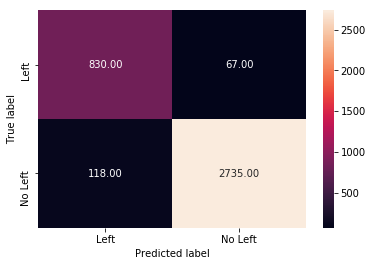

In [47]:
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

### Cross_val_score

- Cross_val_score returns an ndarray of score for each cv set unlike gscv which returns a classifier/regressor for each model made, that classifier has attributes like score,best_params

In [48]:
tree_cross = cross_val_score(estimator=clf_tree,X= train_X,y = train_y,cv=10,scoring='accuracy',n_jobs=-1)

In [50]:
tree_cross

array([0.94849023, 0.95737123, 0.94582593, 0.96447602, 0.94844444,
       0.95017794, 0.94572954, 0.95907473, 0.95462633, 0.95284698])

### GridsearchCV

- GridsearchCV is a advancemnt on Cross_val_score where we are simply looping for each parmeter in param_grid       for the specified CV value and for 10 cv folds we get a mean value which is its scoring unlike for cv_score above where we get scores for each cv model.


- basically each score in gscv is a mean of 10 cv scores in the model abocvr

- basically gridsearchCV is a bag of n varient classifier(Can be DT or anything or even regressor).


- we can use all(predict,fit,score etc) attribute of a DT_classifier with gridsearchCV Object coz its just abag of n classifier

In [35]:
# another way of instantiating a dictionary
#param_grid = dict(max_depth = np.arange(10, 20),max_features=np.arange(5,10)) 
param_grid = {'max_depth': np.arange(10, 20),
             'max_features': np.arange(5,10)}
param_grid

{'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 'max_features': array([5, 6, 7, 8, 9])}

In [36]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 10,n_jobs=-1,scoring=('accuracy'))
tree.fit( train_X, train_y )

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'max_features': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

#### Parameters

In [37]:
tree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [38]:
tree.best_params_

{'max_depth': 15, 'max_features': 9}

### comparing accuracy from training vs best_estimater.score --------------------------------

In [39]:
y_pred = tree.best_estimator_.predict(train_X)

In [40]:
tree_test_pred2 = pd.DataFrame( { 'actual':  train_y,
                            'predicted': tree.best_estimator_.predict( train_X ) } )

In [41]:
tree_test_pred2.head()


,actual,predicted
14480,1,1
1934,1,1
7900,0,0
2952,0,0
4367,0,0


In [42]:
metrics.accuracy_score(tree_test_pred2.actual,tree_test_pred2.predicted)

0.9963552315761401

##### --------------------------------------------------------------------------------------------------------------------------------------

In [43]:
tree.best_score_

0.9806204995999644

In [44]:
## this is basically a list containing dict for each DT model built.
## the model with the max "mean"  value is the best_estimater


## Here "mean" is mean of CV score(10 in this case).
## Now CV score is calc on unseen data unlike the accuracy(above) which is calc against train_y for a model
## built on fit(train_x,train_y).
tree.grid_scores_[:5]

[mean: 0.96764, std: 0.00887, params: {'max_depth': 10, 'max_features': 5},
 mean: 0.97004, std: 0.00796, params: {'max_depth': 10, 'max_features': 6},
 mean: 0.97609, std: 0.00384, params: {'max_depth': 10, 'max_features': 7},
 mean: 0.97751, std: 0.00418, params: {'max_depth': 10, 'max_features': 8},
 mean: 0.97911, std: 0.00383, params: {'max_depth': 10, 'max_features': 9}]

In [47]:
## This is passed when we are declaring the gridsearchcv object
tree.scorer_ # tells what scoring we have used

make_scorer(accuracy_score)

# Building Final Decision Tree Model

In [48]:
y_pred = tree.best_estimator_.predict(test_X)
#y_pred.sum()

In [50]:
tree_test_pred1 = pd.DataFrame( { 'actual':  test_y,
                            'predicted': tree.best_estimator_.predict( test_X ) } )

In [51]:
## selecting a sample from a dataframe

tree_test_pred1.sample( n = 5 )

,actual,predicted
9545,0,0
4355,0,0
8627,0,0
11554,0,0
6463,0,0


### Evaluation_metric

In [52]:
metric = {'accuracy':metrics.accuracy_score(tree_test_pred1.actual,tree_test_pred1.predicted),
'roc_auc_score':metrics.roc_auc_score(tree_test_pred1.actual,tree_test_pred1.predicted),
'mean_absolute_error':metrics.mean_absolute_error(tree_test_pred1.actual,tree_test_pred1.predicted),
'precision_score':metrics.precision_score(tree_test_pred1.actual,tree_test_pred1.predicted)}

In [53]:
pd.DataFrame(metric,index=['scores']).T

,scores
accuracy,0.979733
roc_auc_score,0.972541
mean_absolute_error,0.020267
precision_score,0.956618


### confusion_matrix

Text(0.5,15,'Predicted label')

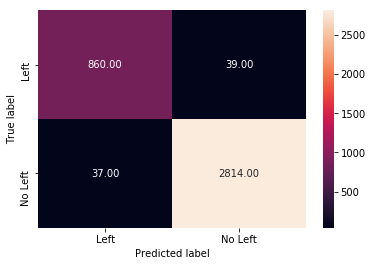

In [54]:
tree_cm = metrics.confusion_matrix( tree_test_pred1.predicted,
                                 tree_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')